# K-Nearest Neighbors

//15 Principles and Techniques for the Professional DA

http://faculty.marshall.usc.edu/gareth-james/

(ref 15)3.5 Comparison of Linear Regression with K-Nearest Neighbors

value of K that was chosen automatically using an approach called
cross-validation, When the true decision boundaries are linear, then
the LDA and logistic regression approaches will tend to perform well.When
the boundaries are moderately non-linear, QDA may give better results.
Finally, for much more complicated decision boundaries, a non-parametric
approach such as KNN can be superior

The technique was first described by E. Fix and J. L. Hodges in 1951 in their paper “Discriminatory
Analysis: Nonparametric Discrimination: Consistency Properties” (a work that
was later republished in 1989) and by 1967 had been studied suffi ciently that its
theoretical qualities were known, namely that k-NN is a universal approximator
with worst-case error that is bounded.

In theory we would always like to predict qualitative responses using the
Bayes classifier. But for real data, we do not know the conditional distribution
of Y given X, and so computing the Bayes classifier is impossible.

When K = 1, the decision boundary is overly
flexible and finds patterns in the data that don’t correspond to the Bayes
decision boundary. This corresponds to a classifier that has low bias but
very high variance. As K grows, the method becomes less flexible and
produces a decision boundary that is close to linear. This corresponds to
a low-variance but high-bias classifier.

The Curse of Dimensionality

One of the challenges with k-NN and other distance-based algorithms is the
number of inputs used in building a model. As the number of inputs increases,
the number of records needed to populate the data space suffi ciently increases
exponentially. If the size of the space increases without increasing the number
of records to populate the space, records could be closer to the edge of the data
space than they are to each other, rendering many, if not all, records as outliers.
This is the curse of dimensionality.

One solution to the curse of dimensionality is to keep dimensionality low;
include only a dozen to a few dozen inputs in k-NN models.

Some k-NN software includes an option to weight the votes of the nearest neighbors
by the distance the neighbor is from the data point

Also, feature scaling (standardization and normalization) is required before applying the KNN algorithm to any dataset; other wise, KNN may generate wrong predictions.

In [4]:
# Import Libraries

# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

# Classifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Retrive Data


# Load locally stored data
df = pd.read_csv('spy.csv', index_col=0, parse_dates=True)

# Check first 5 values 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-03,144.0000,144.000000,139.781250,140.750000,94.913345,12630700
2000-05-04,142.0000,142.359375,140.750000,141.812500,95.629852,5963600
2000-05-05,141.0625,144.000000,140.937500,143.531250,96.788887,7862400
2000-05-08,142.7500,143.375000,141.843750,142.453125,96.061813,5064100
2000-05-09,143.0625,143.406250,140.265625,141.312500,95.292702,5620300


In [5]:
# Descriptive statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5.282000e+03
mean,169.326065,170.315267,168.241714,169.330866,145.099869,1.127701e+08
std,72.787398,73.053712,72.486086,72.802711,80.429296,9.675910e+07
min,67.949997,70.000000,67.099998,68.110001,53.329201,1.436600e+06
25%,116.727501,117.500000,115.692501,116.599998,86.609749,5.020208e+07
50%,139.195000,140.114685,138.075005,139.224998,107.763489,8.366630e+07
75%,209.302498,210.179996,208.387500,209.337498,187.732659,1.488015e+08
max,420.320007,420.720001,416.899994,420.059998,420.059998,8.710263e+08


In [6]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Feature Specification

Features are also known as an independent variable which are used to determine the value of the target variable. We will use the absolute change between Open-Close price and High-Low price as predictors.

In [7]:
# Predictors
df['O-C'] = df['Open'] - df['Close']
df['H-L'] = df['High'] - df['Low']

X = df[['O-C', 'H-L']].values
X[:5]

array([[ 3.25    ,  4.21875 ],
       [ 0.1875  ,  1.609375],
       [-2.46875 ,  3.0625  ],
       [ 0.296875,  1.53125 ],
       [ 1.75    ,  3.140625]])

In [8]:
X.shape # Predictors should be of 2D

(5282, 2)

##  Define Label

Label or the target variable is also known as the dependent variable. Here, the target variable is whether SPY price will close up or down on the next trading day. If the tomorrow’s closing price is greater than today’s closing price, then we will buy the SPY, else we will sell SPY.

We assign a value of +1 for the buy signal and -1 for the sell signal to target variable. 

In [9]:
# Target
y = np.where(df['Adj Close'].shift(-1)>0.995*df['Adj Close'],1,-1) 
y

array([ 1,  1, -1, ...,  1, -1, -1])

In [10]:
y = np.where(df['Adj Close'].shift(-1)>0.995*df['Adj Close'],1,-1)
y

array([ 1,  1, -1, ...,  1, -1, -1])

In [11]:
y.shape  # Target Label should be 1D

(5282,)

In [12]:
## Split Data

In [13]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size:  {len(X_train)}, {len(X_test)}")

Train and Test Size:  4753, 529


## Fit Model
Since the KNN model calculates distances, the dataset needs to be scaled for the model to work properly. All the features should have a similar scale. The scaling can be accomplished by using the MinMaxScaler transformer.

In [14]:
# Scale and fit the model
pipe = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", KNeighborsClassifier())
]) 
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

In [15]:
# Target classes
class_names = pipe.classes_
class_names

array([-1,  1])

## Predict Model

In [16]:
# Predicting the test dataset
y_pred = pipe.predict(X_test)

In [17]:
acc_train = accuracy_score(y_train, pipe.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

In [18]:
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.7875, Test Accuracy: 0.6975


## Prediction Quality

## Confusion Matrix

Confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known.

**True Positive** is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

**False Positive** is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

In [19]:
# Confusion Matrix for binary classification
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

35 84 76 334


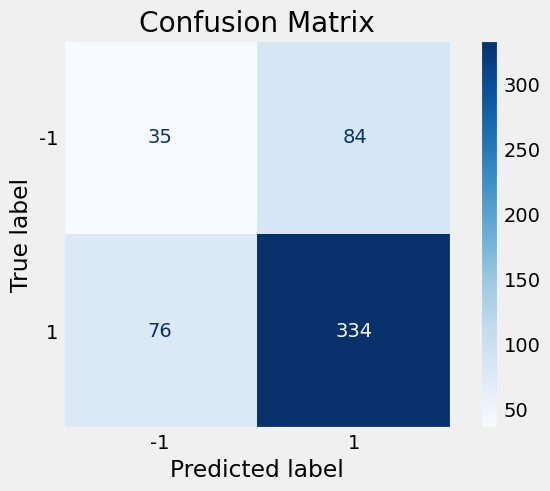

In [20]:
# Plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)

Accuracy = Number of correct predictions / Total number of predictions

Precision = TP / (TP + FP) = Correctly predicted / Total predicted

Recall = TP / (TP / FN) = Correctly predicted / Actuals

F1 score = TP / (TP + 0.5*(FP + FN))

Receiver Operator Characterisitc Curve (ROC)

The ROC curve isa created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.

Area Under ROC Curve

The area under the ROC curve (AUC) is a measure of how well a model can distinguish between two classes.

In [21]:
# Predict Probabilities
probs = pipe.predict_proba(X_test)
preds1 = probs[:, 0]
preds2 = probs[:, 1]

fpr1, tpr1, threshold1 = roc_curve(y_test, preds1, pos_label=-1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(y_test, preds2, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)

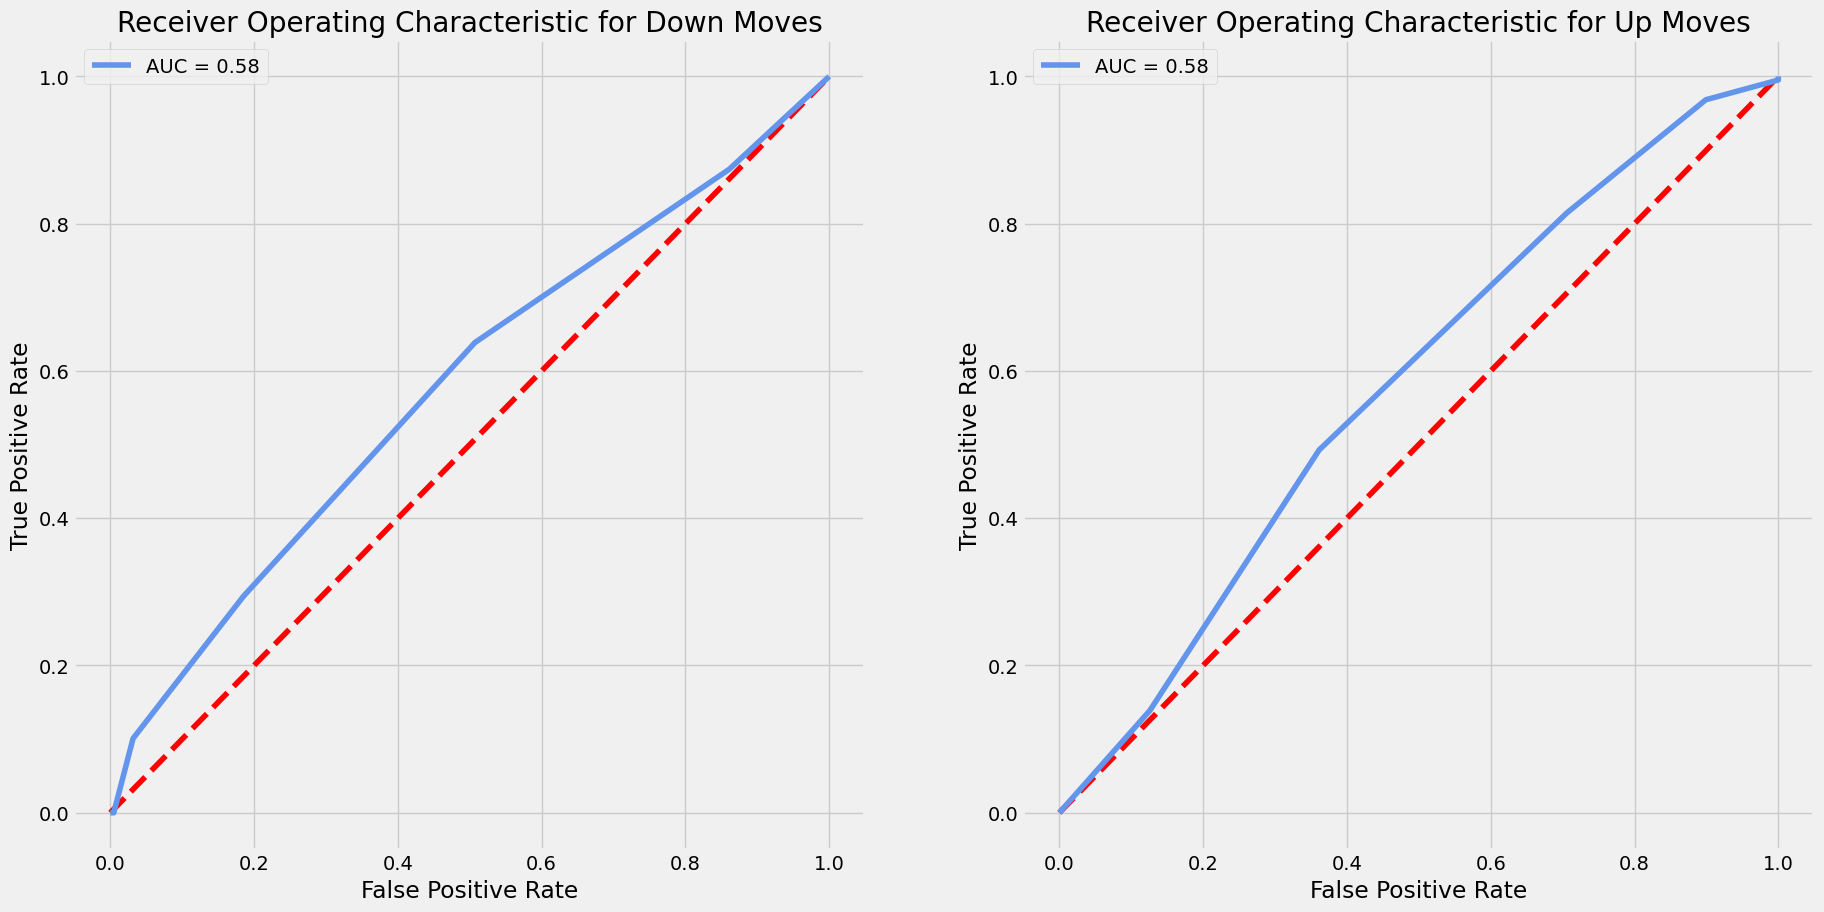

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax[0].plot([0, 1], [0, 1], 'r--')
ax[0].plot(fpr1, tpr1, 'cornflowerblue', label=f'AUC = {roc_auc1:0.2}')
ax[0].set_title("Receiver Operating Characteristic for Down Moves")
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].plot(fpr2, tpr2, 'cornflowerblue', label=f'AUC = {roc_auc2:0.2}')
ax[1].set_title("Receiver Operating Characteristic for Up Moves")
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')

# Define legend
ax[0].legend(), ax[1].legend();

## Classification Report

A classification report is used to measure the quality of predictions from a classification algorithm.

In [23]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.32      0.29      0.30       119
           1       0.80      0.81      0.81       410

    accuracy                           0.70       529
   macro avg       0.56      0.55      0.56       529
weighted avg       0.69      0.70      0.69       529



**Macro Average** 

Average of precision (or recall or f1-score) of different classes.

**Weighted Average** 

Actual Class1 instance precision (or recall or f1-score) of Class1 + Actual Class2 instance (or recall or f1-score) of Class2.

## Hyper-parameter Tuning**
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. It is possible and recommended to search the hyper-parameter space for the best cross validation score. Any parameter provided when constructing an estimator may be optimized in this manner.

## Cross-validation of Time Series

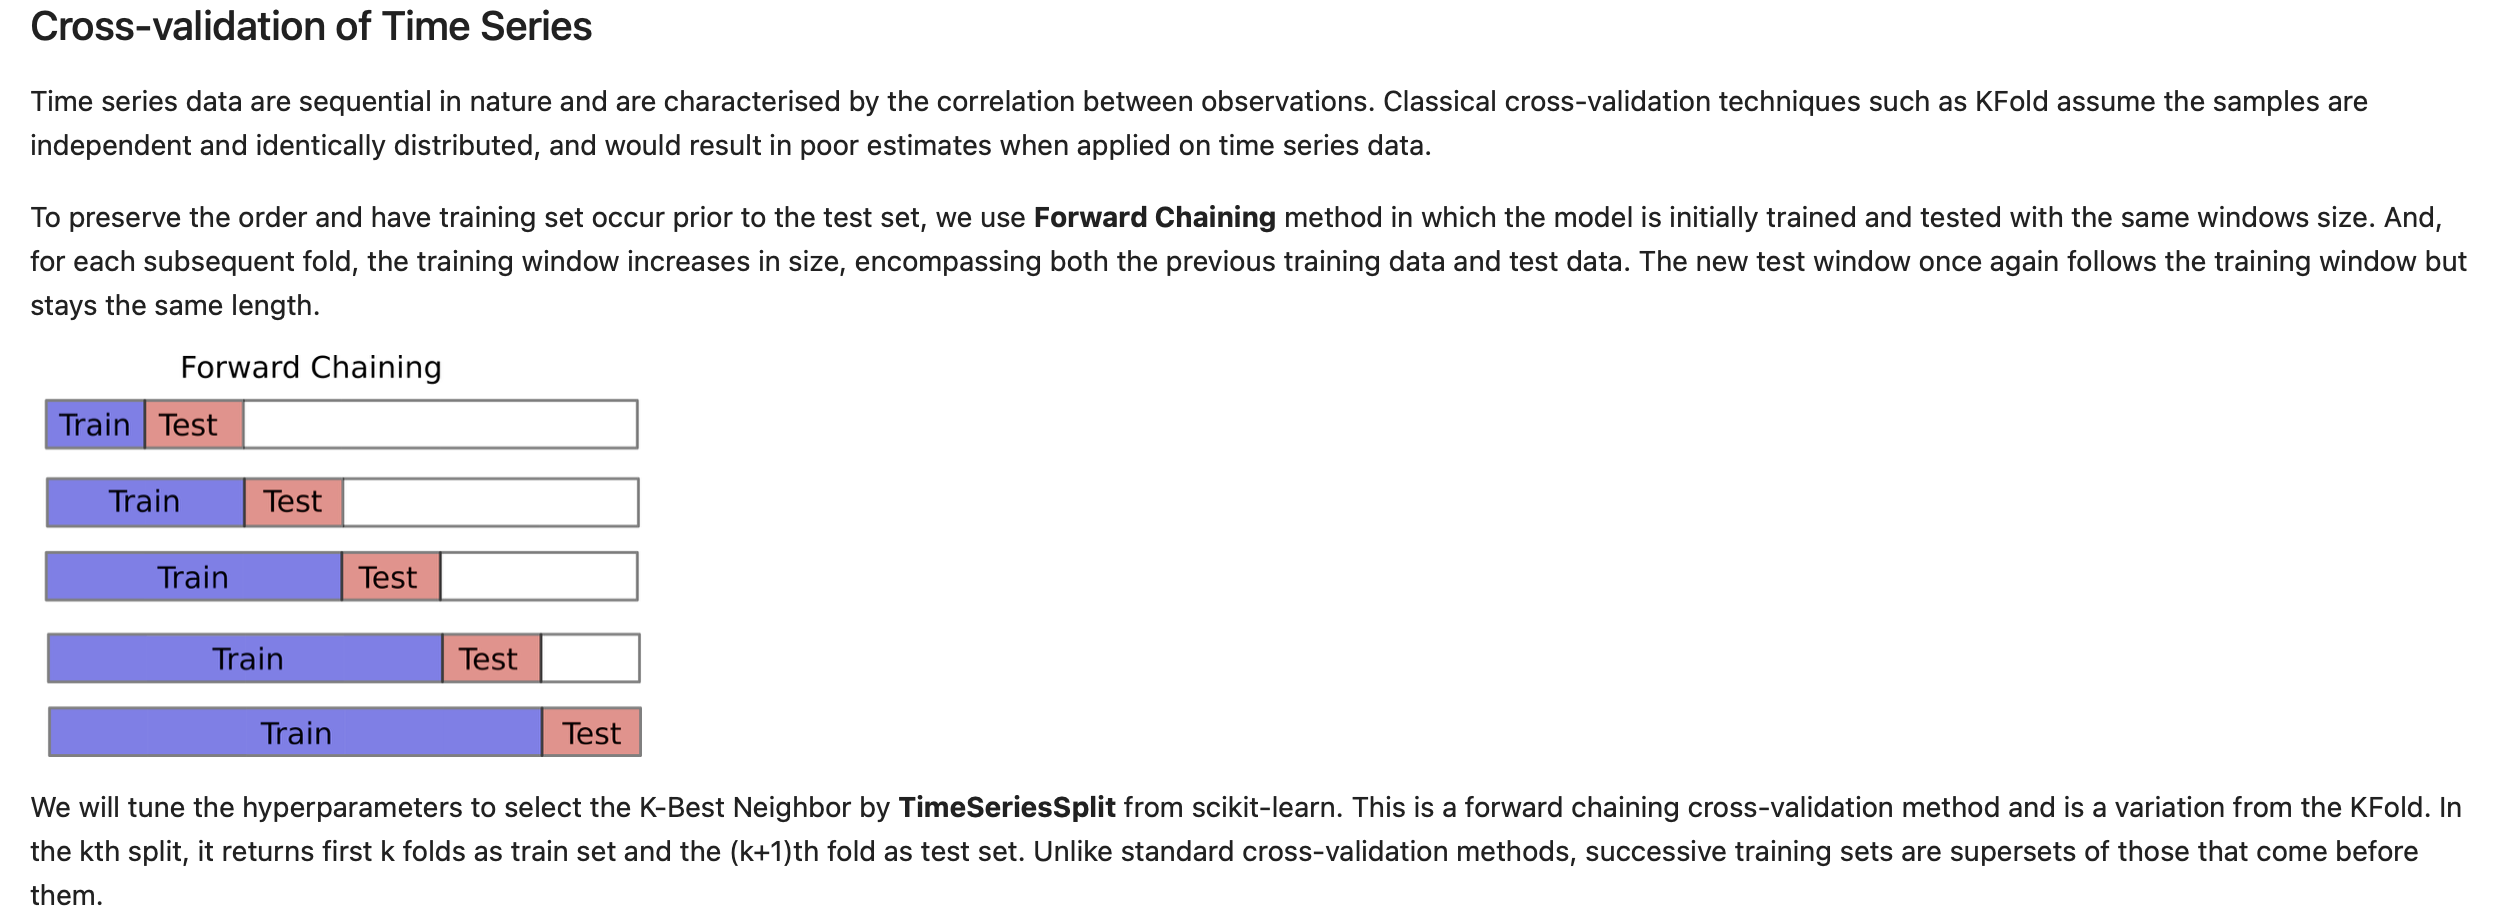

We will tune the hyperparameters to select the K-Best Neighbor by TimeSeriesSplit from scikit-learn. This is a forward chaining cross-validation method and is a variation from the KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set. Unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [24]:
# First 3 split
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X):
    print(train)

[   0    1    2 ... 1319 1320 1321]
[   0    1    2 ... 2639 2640 2641]
[   0    1    2 ... 3959 3960 3961]


In [25]:
print(test)

[3962 3963 3964 ... 5279 5280 5281]


In [26]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

## GridSearch

The conventional way of performing hyperparameter optimization has been a grid search (aka parameter sweep). It is an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a validation set.

GridSearch performs exhaustive search over specified parameter values for an estimator. It implements a “fit” and a “score” method among other methods. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [27]:
# Get parameters list
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [28]:
# Perform Gridsearch and fit
param_grid = {"classifier__n_neighbors": np.arange(1,51,1)}

grid_search = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [29]:
# Best Params
grid_search.best_params_

{'classifier__n_neighbors': 49}

In [30]:
# Best Score
grid_search.best_score_

0.5494313710393317

## Elbow Method

KNN works by finding the nearest K Kneighbors of an observation and using those neighboring points to make a prediction. The most important step is to determine the optimal value of K - which is, how many clusters the data should be divided into? Elbow method helps us to select the optimal number of clusters for KNN clustering. It is one of the most popular methods to determine the optimal value of K.


In [31]:
error_rate = []
acc_score = []

for i in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    acc_score.append(accuracy_score(y_test, pred_i))

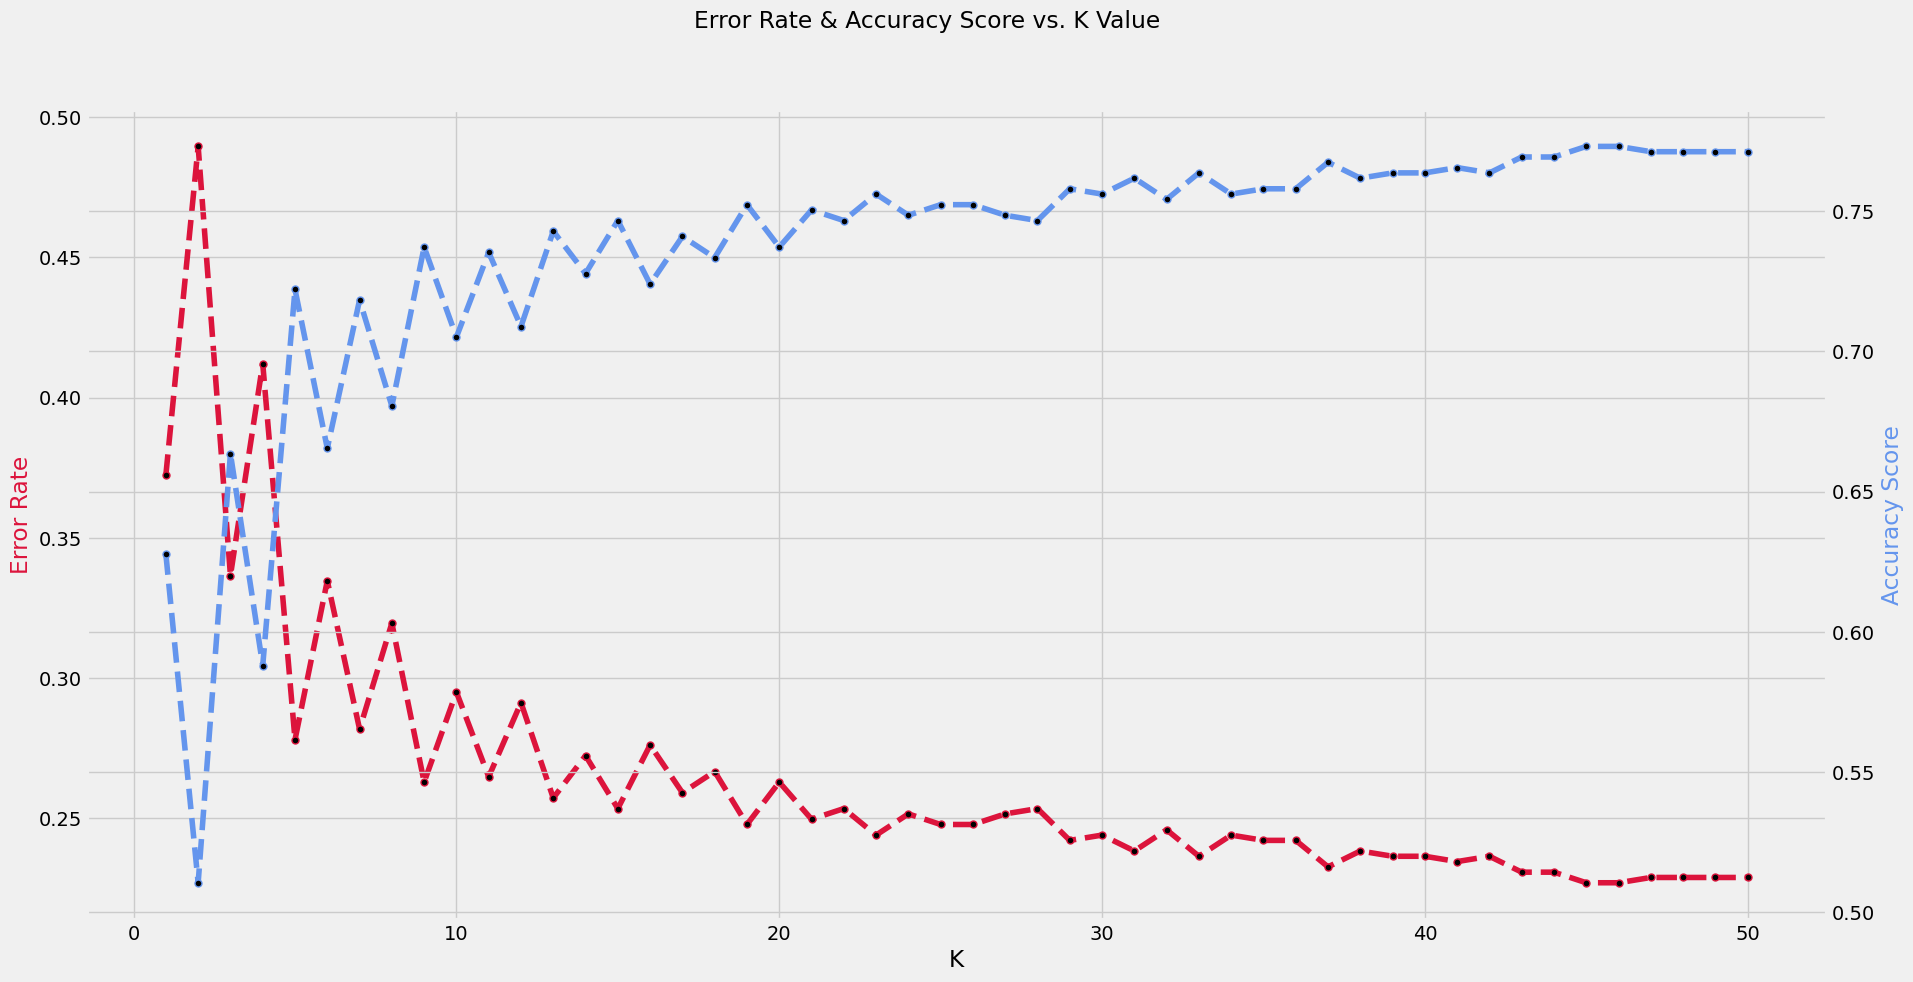

In [32]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(range(1,51), error_rate, color= 'crimson', linestyle='dashed',  marker='o', markerfacecolor='black', markersize=5)
ax2.plot(range(1,51), acc_score, color='cornflowerblue', linestyle='dashed', marker='o', markerfacecolor='black', markersize=5)

ax1.set_xlabel('K')
ax1.set_ylabel('Error Rate', color='crimson')
ax2.set_ylabel('Accuracy Score', color='cornflowerblue')

fig.suptitle('Error Rate & Accuracy Score vs. K Value');

## Fit & Predict

Let's now train and predict the model with search parameter

In [33]:
# Instantiate KNN model with search param
clf = KNeighborsClassifier(n_neighbors = grid_search.best_params_['classifier__n_neighbors'])

In [34]:
# Fit the model
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=49)

In [35]:
# Predicting the test dataset
y_pred = clf.predict(X_test)

In [36]:
# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

In [37]:
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.7616 
 Test Accuracy 		: 0.7713


In [38]:
# Confusion Matrix for binary classification
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

0 119 2 408


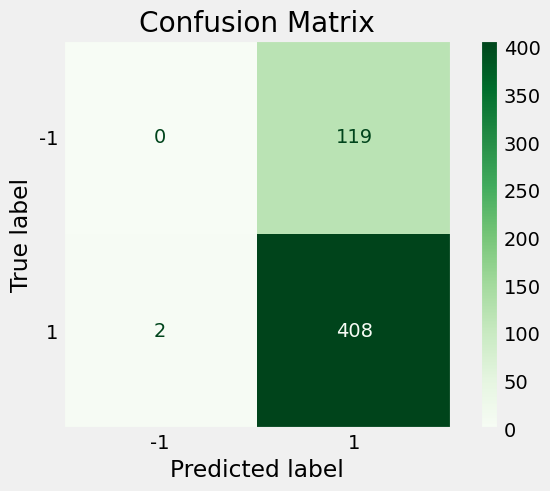

In [39]:
# Plot confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap='Greens')
plt.title('Confusion Matrix')
plt.grid(False)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,plot_confusion_matrix, plot_roc_curve

In [41]:
# estimate accuracy on validation set

print(accuracy_score(y_test, y_pred ))
print(confusion_matrix(y_test, y_pred ))
print(classification_report(y_test, y_pred ))

0.7712665406427222
[[  0 119]
 [  2 408]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       119
           1       0.77      1.00      0.87       410

    accuracy                           0.77       529
   macro avg       0.39      0.50      0.44       529
weighted avg       0.60      0.77      0.67       529



In [42]:
X.shape

(5282, 2)

In [43]:
X_test.shape

(529, 2)

In [44]:
# Predict Probabilities
probs = clf.predict_proba(X_test)
preds1 = probs[:, 0]
preds2 = probs[:, 1]

fpr1, tpr1, threshold1 = roc_curve(y_test, preds1, pos_label=-1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(y_test, preds2, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)

In [45]:
preds1.shape, preds2.shape

((529,), (529,))

In [46]:
probs.shape

(529, 2)

In [47]:
preds2 = probs[:, 1]
preds2.shape

(529,)

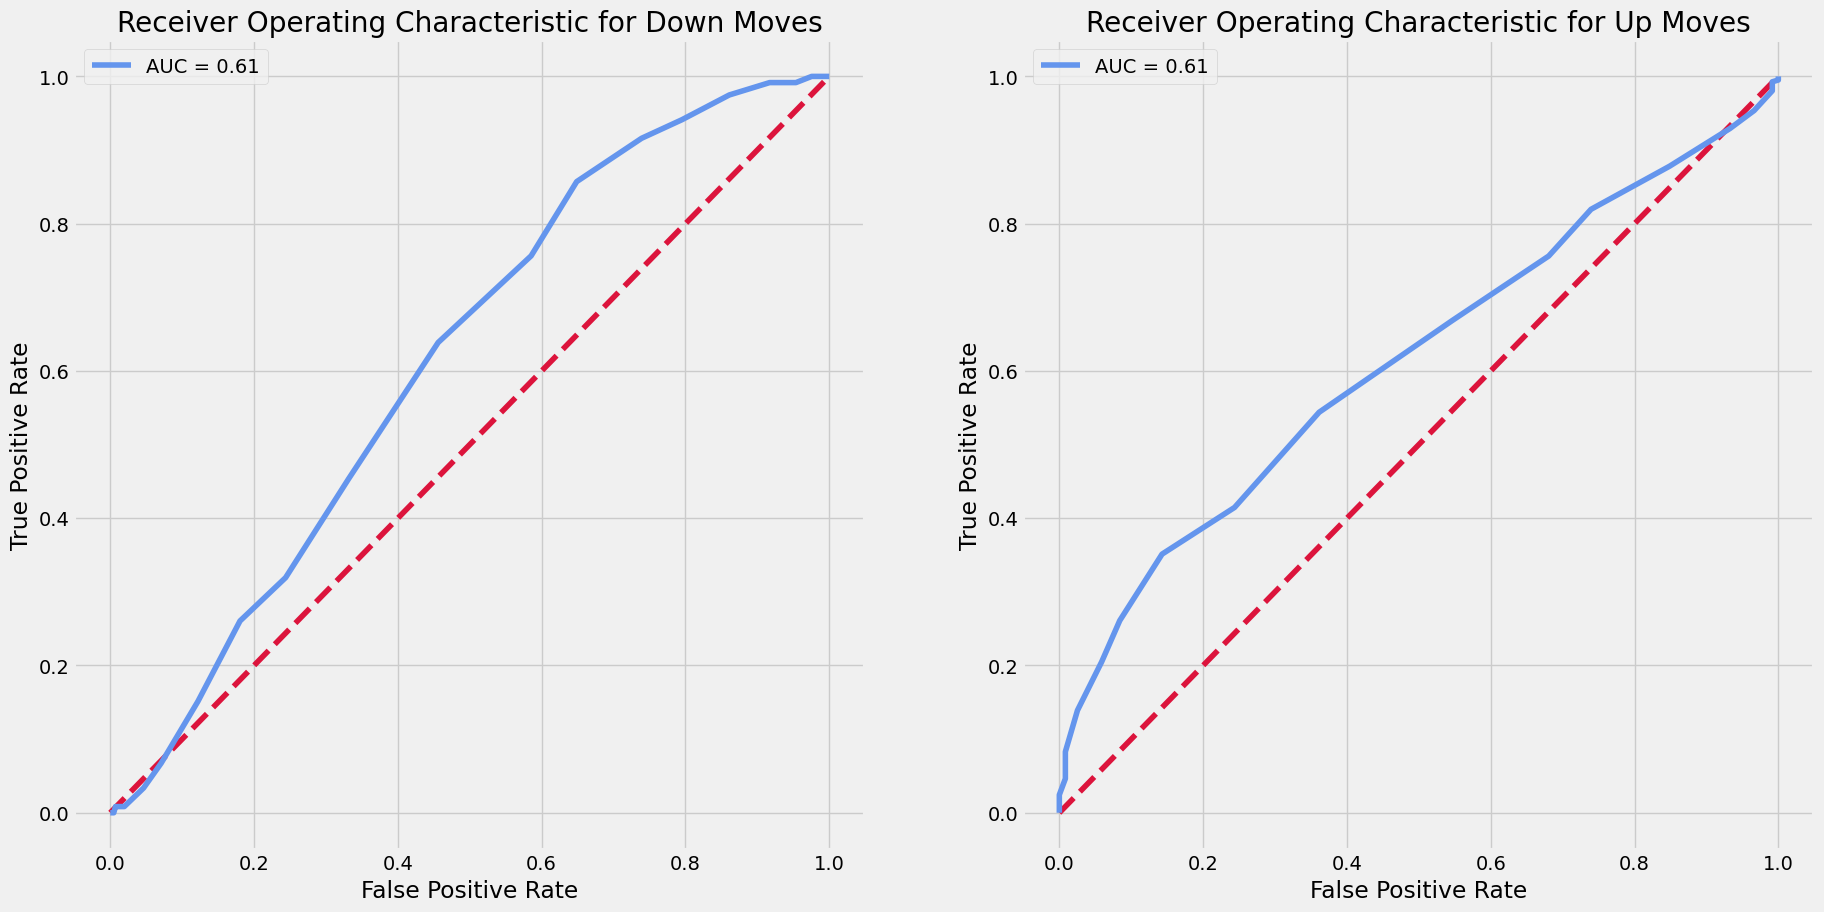

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax[0].plot([0, 1], [0, 1], color= 'crimson', linestyle='dashed')
ax[0].plot(fpr1, tpr1, 'cornflowerblue', label=f'AUC = {roc_auc1:0.2}')
ax[0].set_title("Receiver Operating Characteristic for Down Moves")
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].plot([0, 1], [0, 1], color= 'crimson', linestyle='dashed')
ax[1].plot(fpr2, tpr2, 'cornflowerblue', label=f'AUC = {roc_auc2:0.2}')
ax[1].set_title("Receiver Operating Characteristic for Up Moves")
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')

# Define legend
ax[0].legend(), ax[1].legend();

In [49]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       119
           1       0.77      1.00      0.87       410

    accuracy                           0.77       529
   macro avg       0.39      0.50      0.44       529
weighted avg       0.60      0.77      0.67       529



Observation

Test accuracy improved more than 5% as compared to the earlier model.
Recall for Class +1 improved by 7% as compared to the earlier model while recall for Class -1 decreased by 40%.
Model improved predictor for upside when compared to the downside.

## Trading Strategy

Let's now define a trading strategy. We will use the predicted signal to buy or sell. We then compare the result of this strategy with the buy and hold and visualize the performance of the KNN Algorithm.

In [50]:
df1 = df[-len(X_test):]
df1


,Open,High,Low,Close,Adj Close,Volume,O-C,H-L
Date,,,,,,,,
2019-03-27,281.109985,281.760010,277.929993,279.649994,269.724884,72224700,1.459991,3.830017
2019-03-28,280.350006,281.209991,279.070007,280.709991,270.747253,56238500,-0.359985,2.139984
2019-03-29,282.390015,282.839996,281.140015,282.480011,272.454498,82186800,-0.089996,1.699981
2019-04-01,284.700012,286.160004,284.399994,285.829987,275.685608,77617900,-1.129975,1.760010
2019-04-02,286.040009,286.230011,285.089996,285.970001,275.820648,40070400,0.070008,1.140015
...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400,-0.169983,1.410003
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100,0.410004,1.840027
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900,0.410004,2.110016


In [51]:
df1['Signal'] = clf.predict(X_test)
df1['Signal']

Date
2019-03-27    1
2019-03-28    1
2019-03-29    1
2019-04-01    1
2019-04-02    1
             ..
2021-04-26    1
2021-04-27    1
2021-04-28    1
2021-04-29    1
2021-04-30    1
Name: Signal, Length: 529, dtype: int64

In [52]:
# Buy & Hold
df1['Returns'] = np.log(df1['Adj Close']).diff().fillna(0)
df1

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Signal,Returns
Date,,,,,,,,,,
2019-03-27,281.109985,281.760010,277.929993,279.649994,269.724884,72224700,1.459991,3.830017,1,0.000000
2019-03-28,280.350006,281.209991,279.070007,280.709991,270.747253,56238500,-0.359985,2.139984,1,0.003783
2019-03-29,282.390015,282.839996,281.140015,282.480011,272.454498,82186800,-0.089996,1.699981,1,0.006286
2019-04-01,284.700012,286.160004,284.399994,285.829987,275.685608,77617900,-1.129975,1.760010,1,0.011789
2019-04-02,286.040009,286.230011,285.089996,285.970001,275.820648,40070400,0.070008,1.140015,1,0.000490
...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400,-0.169983,1.410003,1,0.002085
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100,0.410004,1.840027,1,-0.000216
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900,0.410004,2.110016,1,-0.000287


In [53]:
cumret = df1['Returns'].cumsum().apply(np.exp)

In [54]:
cumret

Date
2019-03-27    1.000000
2019-03-28    1.003790
2019-03-29    1.010120
2019-04-01    1.022099
2019-04-02    1.022600
                ...   
2021-04-26    1.548281
2021-04-27    1.547948
2021-04-28    1.547503
2021-04-29    1.557365
2021-04-30    1.547132
Name: Returns, Length: 529, dtype: float64

In [55]:
type(df1)

pandas.core.frame.DataFrame

In [56]:
# KNN Algorithm
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)
cumstg = df1['Strategy'].cumsum().apply(np.exp)
cumstg

Date
2019-03-27    1.000000
2019-03-28    1.003790
2019-03-29    1.010120
2019-04-01    1.022099
2019-04-02    1.022600
                ...   
2021-04-26    1.526035
2021-04-27    1.525706
2021-04-28    1.525268
2021-04-29    1.534988
2021-04-30    1.524902
Name: Strategy, Length: 529, dtype: float64

In [57]:
# Check the output
df1

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Signal,Returns,Strategy
Date,,,,,,,,,,,
2019-03-27,281.109985,281.760010,277.929993,279.649994,269.724884,72224700,1.459991,3.830017,1,0.000000,0.000000
2019-03-28,280.350006,281.209991,279.070007,280.709991,270.747253,56238500,-0.359985,2.139984,1,0.003783,0.003783
2019-03-29,282.390015,282.839996,281.140015,282.480011,272.454498,82186800,-0.089996,1.699981,1,0.006286,0.006286
2019-04-01,284.700012,286.160004,284.399994,285.829987,275.685608,77617900,-1.129975,1.760010,1,0.011789,0.011789
2019-04-02,286.040009,286.230011,285.089996,285.970001,275.820648,40070400,0.070008,1.140015,1,0.000490,0.000490
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400,-0.169983,1.410003,1,0.002085,0.002085
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100,0.410004,1.840027,1,-0.000216,-0.000216
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900,0.410004,2.110016,1,-0.000287,-0.000287


In [58]:
cumret['2019']

Date
2019-03-27    1.000000
2019-03-28    1.003790
2019-03-29    1.010120
2019-04-01    1.022099
2019-04-02    1.022600
                ...   
2019-12-24    1.165305
2019-12-26    1.171508
2019-12-27    1.171217
2019-12-30    1.164760
2019-12-31    1.167590
Name: Returns, Length: 194, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


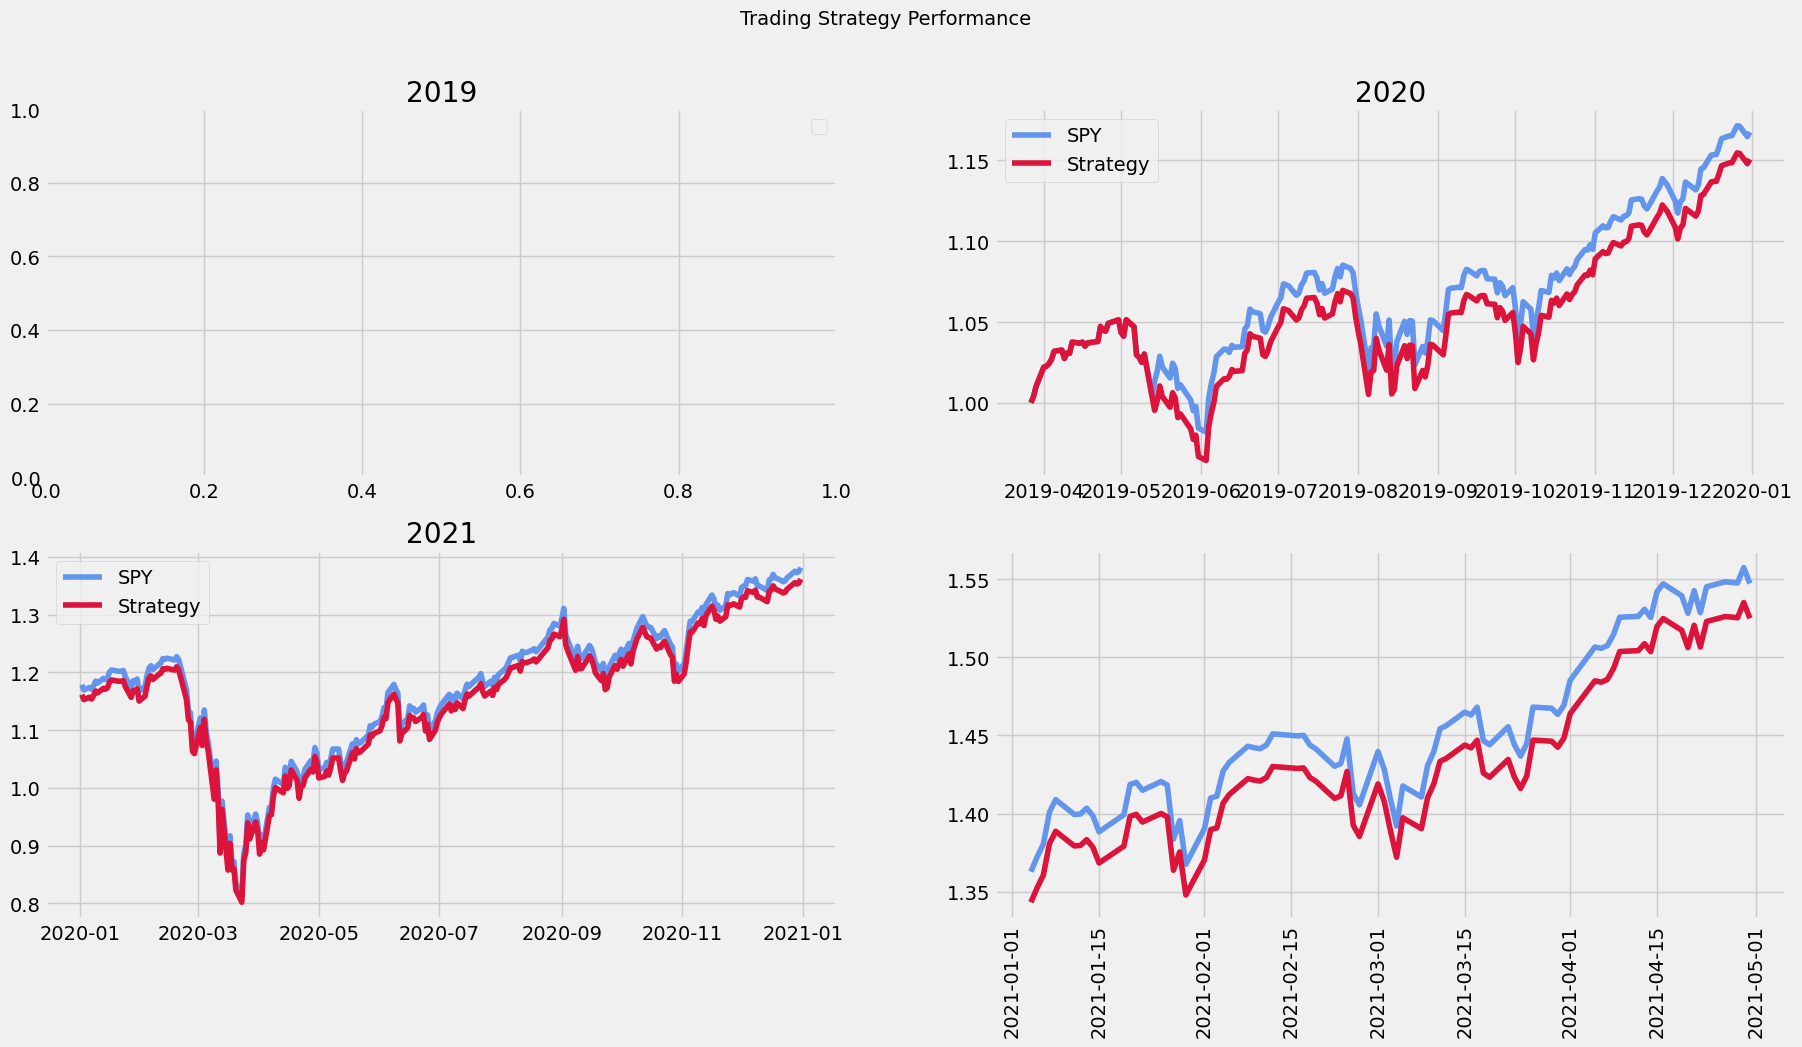

In [59]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))


# 2019
ax[0,1].plot(cumret['2019'], label ='SPY', color ='cornflowerblue')
ax[0,1].plot(cumstg['2019'], label ='Strategy', color ='crimson')
# 2020
ax[1,0].plot(cumret['2020'], label ='SPY', color ='cornflowerblue')
ax[1,0].plot(cumstg['2020'], label ='Strategy', color ='crimson')

# 2021
ax[1,1].plot(cumret['2021'], label ='SPY', color ='cornflowerblue')
ax[1,1].plot(cumstg['2021'], label ='Strategy', color ='crimson')
ax[1,1].tick_params(axis='x', rotation=90)

# Set axis title
ax[0,0].set_title('2019'), ax[0,1].set_title('2020'), ax[1,0].set_title('2021'), 

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend()

fig.suptitle('Trading Strategy Performance', fontsize=14);

In [60]:
# Cumulative returns
print(' Benchmark & Strategy Returns')
print(f'\n Benchmark Return \t: {cumret[-1]:0.4} \n KNN Strategy Return \t: {cumstg[-1]:0.4}')

 Benchmark & Strategy Returns

 Benchmark Return 	: 1.547 
 KNN Strategy Return 	: 1.525


In [63]:
! pip install pyfolio -q

In [64]:
# Import pyfolio
import pyfolio as pf

In [65]:
df1['Strategy']

Date
2019-03-27    0.000000
2019-03-28    0.003783
2019-03-29    0.006286
2019-04-01    0.011789
2019-04-02    0.000490
                ...   
2021-04-26    0.002085
2021-04-27   -0.000216
2021-04-28   -0.000287
2021-04-29    0.006353
2021-04-30   -0.006592
Name: Strategy, Length: 529, dtype: float64

Start date,2019-03-27
End date,2021-04-30
Total months,25
,Backtest
Annual return,18.4%
Cumulative returns,42.7%
Annual volatility,25.0%
Sharpe ratio,0.80
Calmar ratio,0.52
Stability,0.52
Max drawdown,-35.7%


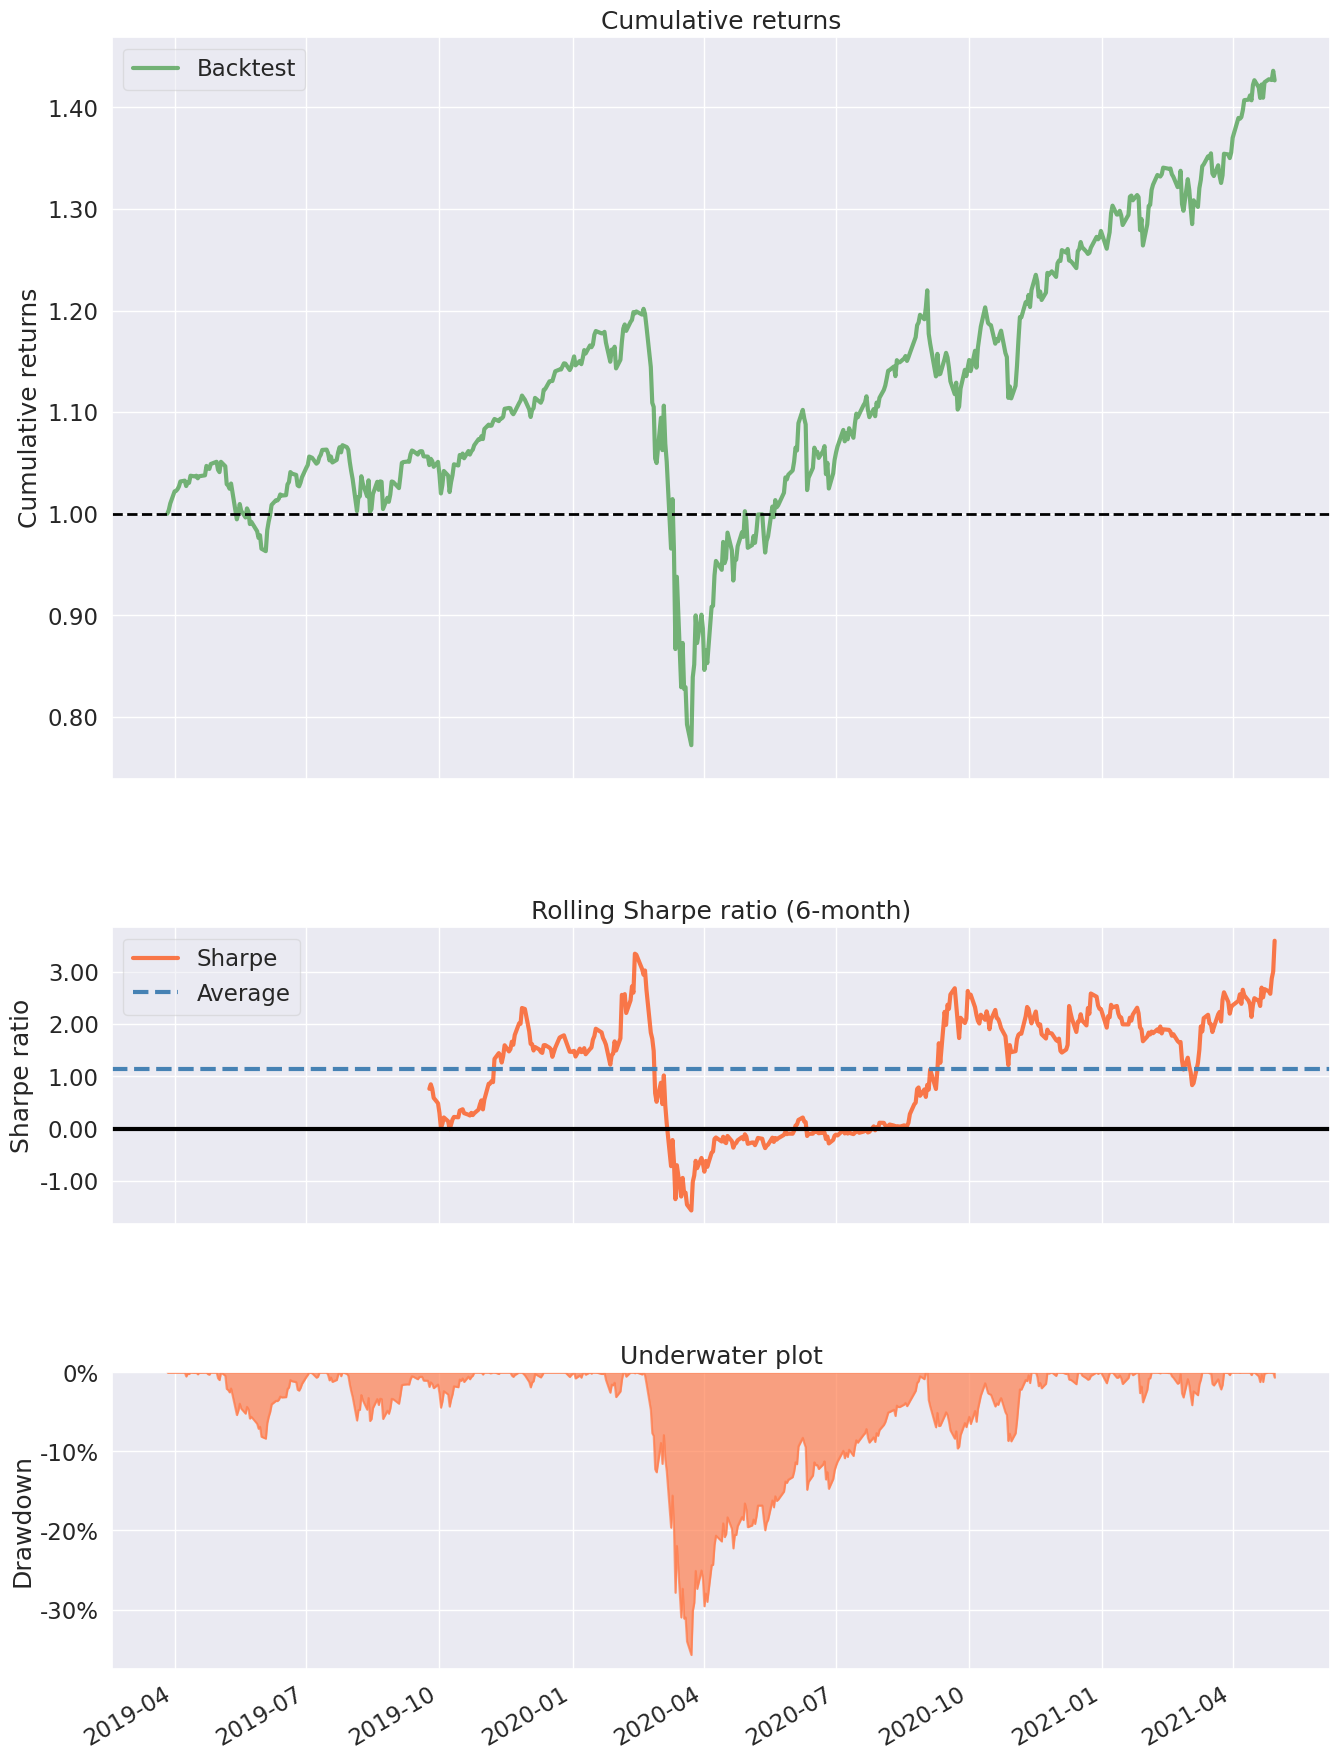

In [66]:
# Create Tear sheet using pyfolio for outsample
pf.create_simple_tear_sheet(df1['Strategy'])